In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, Lambda
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms





In [2]:
print(torch.__version__)

2.2.1


In [3]:
# Set font to match Latex
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
})

In [4]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())


In [5]:
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=ToTensor())

In [6]:
train_image = []
train_target = []

for data in mnist_trainset:
    image, target = data
    train_image.append(image)
    train_target.append(target)

In [7]:
mnist_trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [8]:
mnist_testset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [9]:
test_image = []
test_target = []

for data in mnist_testset:
    image, target = data
    test_image.append(image)
    test_target.append(target)

7


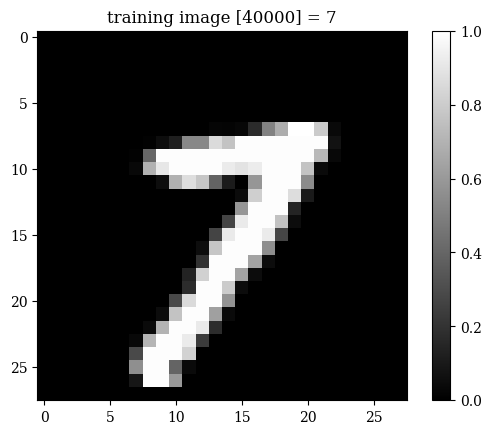

In [36]:
print(train_target[40000])
plt.imshow(train_image[40000].view(28,28), cmap='gray')
plt.colorbar()
plt.title('Training image [' + str(40000) + '] = ' + str(train_target[40000]))
plt.savefig('trainDataSetnr.pdf')

9


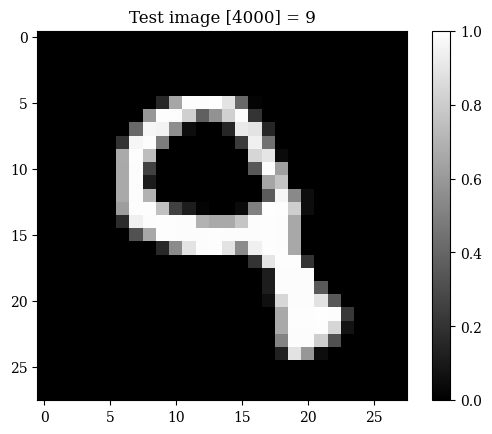

In [38]:
print(test_target[4000])
plt.imshow(test_image[4000].view(28,28), cmap='gray')
plt.colorbar()
plt.title('Test image [' + str(4000) + '] = ' + str(test_target[4000]))
plt.savefig('testDataSetnr.pdf')

## Problem Two: Singel Hidden Layer

In [42]:
# Device configuration (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters 
input_size = 28 * 28  # MNIST images are 28x28 pixels
hidden_size = 500  # Size of the hidden layer
num_classes = 10 # Number of unique classes the model should be able to predict
num_epochs = 10
batch_size = 100
learning_rate = 0.01

train_loader = torch.utils.data.DataLoader(dataset=mnist_trainset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=mnist_testset,
                                          batch_size=batch_size,
                                          shuffle=False)

# Fully connected FeedForward network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Model, loss function, optimizer
model = NeuralNet(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss() #measures deviation between predicted and actual classes
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Training Loop
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, input_size).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation accuracy after each epoch
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.reshape(-1, input_size).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Epoch: {epoch+1}, Loss: {loss.item():.4f}, Validation Accuracy: {accuracy:.2f}%')

Epoch: 1, Loss: 0.6530, Validation Accuracy: 84.20%
Epoch: 2, Loss: 0.4653, Validation Accuracy: 87.96%
Epoch: 3, Loss: 0.4275, Validation Accuracy: 89.36%
Epoch: 4, Loss: 0.2767, Validation Accuracy: 90.11%
Epoch: 5, Loss: 0.2589, Validation Accuracy: 90.55%
Epoch: 6, Loss: 0.3808, Validation Accuracy: 91.09%
Epoch: 7, Loss: 0.3518, Validation Accuracy: 91.46%
Epoch: 8, Loss: 0.4120, Validation Accuracy: 91.70%
Epoch: 9, Loss: 0.1791, Validation Accuracy: 92.04%
Epoch: 10, Loss: 0.2768, Validation Accuracy: 92.20%
